# Trait correlations study 2 analysis

Import packages:

In [3]:
%matplotlib inline
import numpy as np
import pandas as pd
from scipy.spatial.distance import squareform, pdist
from scipy.stats import rankdata, pearsonr
import statsmodels.api as sm
from statsmodels.stats.mediation import Mediation
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr

def vec_rescale(vec, new_min, new_max):
    '''
    Rescale vector to new min and max value
    '''
    return (new_max - new_min) / ( max(vec) - min(vec) ) * (vec - max(vec)) + new_max

## Data prep

Load in raw data and transform into similarity vectors:

In [4]:
# TL1 Face task - Face Judgment DM
faces_raw = pd.pivot_table(pd.read_csv('./faces1_raw.csv'), 
                       index = 'Picture', 
                       columns = 'Name', 
                       values = 'Rating', 
                       aggfunc = np.mean)
facesDM = 1 - pdist(faces_raw.transpose(),metric='correlation')

# TraitCorrelations1 task - Subjective DM 
subjective_raw = pd.pivot_table(pd.read_csv('./traitcorr1_raw.csv'), 
                       index = 'trait_pair',
                       values = 'similarity', 
                       aggfunc = np.mean)
subjectiveDM = subjective_raw['similarity']

# NEOPI Facets - Objective DM
objective_raw = pd.read_csv('./facets_US.csv', index_col='SubjID')
objectiveDM = 1 - pdist(objective_raw.transpose(),metric='correlation')

# Combine data
fso = pd.DataFrame([ facesDM, subjectiveDM, objectiveDM ],
                  ['Faces','Subjective','Objective']).transpose() 

Plot DMs with cluster solutions:

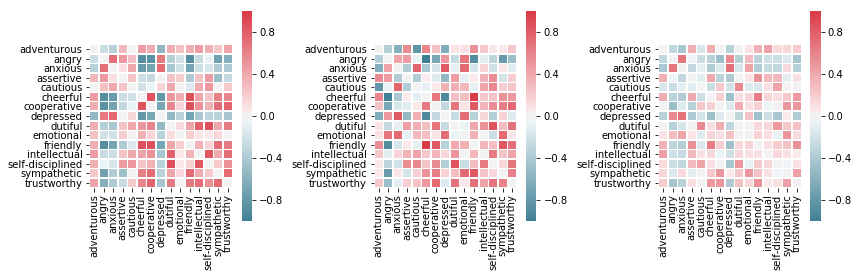

In [5]:
# plot settings
fig, axs = plt.subplots(ncols=3,figsize=(12,4))
labels = faces_raw.columns.values
cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap( pd.DataFrame(squareform(fso['Faces']), columns=labels, index=labels),
            cmap=cmap, center=0, square=True, linewidths=.5, vmin=-1, vmax=1, ax=axs[0] )
sns.heatmap( pd.DataFrame(squareform(vec_rescale(fso['Subjective'],-1,1)), columns=labels, index=labels),
            cmap=cmap, center=0, square=True, linewidths=.5, vmin=-1, vmax=1, ax=axs[1] )
sns.heatmap( pd.DataFrame(squareform(fso['Objective']), columns=labels, index=labels),
            cmap=cmap, center=0, square=True, linewidths=.5, vmin=-1, vmax=1, ax=axs[2] )
plt.tight_layout()

## RSA

Run analyses and plot (plots not rank ordered).

('Faces:Subjective = ', SpearmanrResult(correlation=0.79601590330851058, pvalue=3.4069805921903004e-24))
('Subjective:Objective = ', SpearmanrResult(correlation=0.79347076731707711, pvalue=6.0164589339718519e-24))
('Objective:Faces = ', SpearmanrResult(correlation=0.70733982998133937, pvalue=3.3343064852218372e-17))


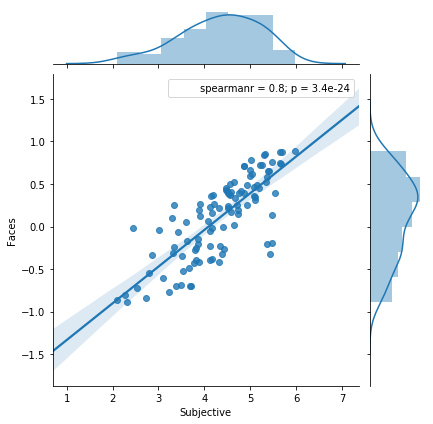

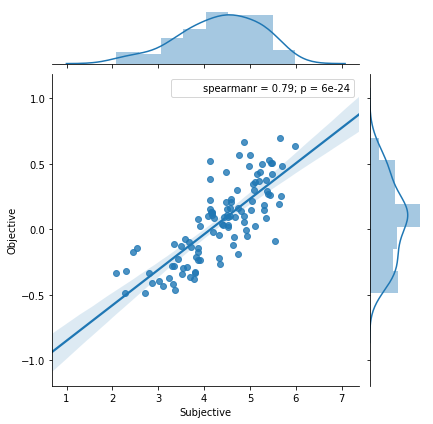

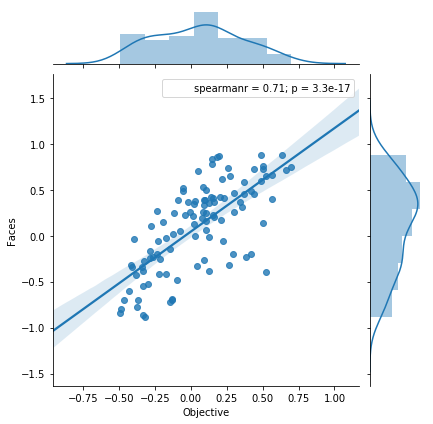

In [11]:
print( 'Faces:Subjective = ', 
      spearmanr(fso['Subjective'],fso['Faces']) )
sns.jointplot("Subjective", "Faces", data=fso, kind="reg", stat_func=spearmanr)

print( 'Subjective:Objective = ', 
      spearmanr(fso['Subjective'],fso['Objective']) )
sns.jointplot("Subjective", "Objective", data=fso, kind="reg", stat_func=spearmanr)

print( 'Objective:Faces = ', 
      spearmanr(fso['Objective'],fso['Faces']) )
sns.jointplot("Objective", "Faces", data=fso, kind="reg", stat_func=spearmanr)

## Mediation analysis

Mediation analysis (ACME average = 'indirect effect', ADE average = 'direct effect')

In [108]:
outcome_model = sm.GLM.from_formula("Faces ~ Subjective + Objective",
                                        fso, family=sm.families.Gaussian())
mediator_model = sm.OLS.from_formula("Subjective ~ Objective", fso)
med = Mediation(outcome_model, mediator_model, "Objective", "Subjective")
med_result = med.fit(n_rep=1000)
print(med_result.summary())
# ACME = indirect effect; ADE = direct effect

                          Estimate  Lower CI bound  Upper CI bound  P-value
ACME (control)            0.763992        0.501567        1.038321     0.00
ACME (treated)            0.763992        0.501567        1.038321     0.00
ADE (control)             0.365783        0.093135        0.651940     0.01
ADE (treated)             0.365783        0.093135        0.651940     0.01
Total effect              1.129775        0.926367        1.355525     0.00
Prop. mediated (control)  0.680264        0.445995        0.904055     0.00
Prop. mediated (treated)  0.680264        0.445995        0.904055     0.00
ACME (average)            0.763992        0.501567        1.038321     0.00
ADE (average)             0.365783        0.093135        0.651940     0.01
Prop. mediated (average)  0.680264        0.445995        0.904055     0.00
